# Задание 6.

Реализовать метод Якоби поиска всех собственных чисел. Использовать две какие-либо стратегии выбора обнуляемого элемента.

* Вычисления проводить до достижения точности ε.
* Варьируя ε, скажем, от 10−2 до 10−5, изучить зависимость количества итераций от ε.
* Обязательно протестировать на матрице Гильберта порядка > 5.
* Выводить количество итераций.
* По теореме Гершгорина определить область, в которую должны попадать с.ч. матрицы. Проверить, действительно ли найденные значения в область попали.

# Imports

In [48]:
from collections import namedtuple
from itertools import product
from math import sqrt
from functools import reduce
from typing import Callable, Tuple
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple
from collections import namedtuple
from math import sqrt

import nbimporter
from common import generate_hilberts_matrix_element, generate_tridiagonal_matrix_element

# Solution

In [39]:
EigenValues = namedtuple('EigenValues', ['eigen_values', 'iterations_count'])

def is_hermitian(matrix: np.ndarray) -> bool:
    """Check if a matrix is Hermitian."""
    return np.allclose(matrix, matrix.conjugate().T)

def find_eigen_values(A: np.ndarray, epsilon: float, max_iterations_count: int, get_element: Callable) -> EigenValues:
    if not is_hermitian(A):
        raise ValueError('Matrix A is not Hermitian.')

    n = A.shape[0]
    A_k = A.copy()
    iterations_count = 0
    i, j = 0, 0

    while True:
        i, j = get_element(A_k, i, j)
        x, y = -2 * A_k[i, j], A_k[i, i] - A_k[j, j]
        c = sqrt((1 + abs(y) / sqrt(x ** 2 + y ** 2)) / 2)
        s = np.sign(x * y) * abs(x) / (2 * c * sqrt(x ** 2 + y ** 2))

        T = np.eye(n)
        T[i, i] = T[j, j] = c
        T[i, j] = -s
        T[j, i] = s

        A_k = T @ A_k @ T.T
        iterations_count += 1

        off_diagonal_sum = np.sum(np.abs(A_k)) - np.sum(np.abs(np.diag(A_k)))
        if off_diagonal_sum < epsilon:
            break

        if iterations_count > max_iterations_count:
            raise ValueError(f'Result not found after {max_iterations_count} iterations.')

    eigen_values = np.diag(A_k)
    return EigenValues(eigen_values, iterations_count)

def get_max_abs_element(A_k: np.ndarray, _: int, __: int) -> Tuple[int, int]:
    n = A_k.shape[0]
    i, j = np.unravel_index(np.argmax(np.abs(A_k - np.diag(np.diag(A_k)))), (n, n))
    return i, j

def get_cyclic_element(A_k: np.ndarray, i: int, j: int) -> Tuple[int, int]:
    n = A_k.shape[0]

    j += 1

    if j >= n or i == j:
        i += 1
        j = 0

        if i == j:
            j += 1

    if i >= n:
        i, j = 0, 1

    return i, j

def find_eigen_values_first_method(A: np.ndarray, epsilon: float, max_iterations_count: int) -> EigenValues:
    return find_eigen_values(A, epsilon, max_iterations_count, get_max_abs_element)

def find_eigen_values_second_method(A: np.ndarray, epsilon: float, max_iterations_count: int) -> EigenValues:
    return find_eigen_values(A, epsilon, max_iterations_count, get_cyclic_element)

# Tests

In [41]:
def generate_random_symmetric_matrix(size):
    """Generate a random symmetric matrix of given size."""
    A = np.random.rand(size, size)
    return A + A.T

def test_eigenvalue_methods_real_only():
    num_matrices=1
    matrix_size=5
    epsilon=1e-5
    max_iterations_count=1000
    
    for _ in range(num_matrices):
        A = generate_random_symmetric_matrix(matrix_size)

        eigen_values_first_method = find_eigen_values_first_method(A.copy(), epsilon, max_iterations_count).eigen_values
        eigen_values_second_method = find_eigen_values_second_method(A.copy(), epsilon, max_iterations_count).eigen_values

        eigen_values_numpy, _ = np.linalg.eigh(A)

        eigen_values_first_method_sorted = np.copy(eigen_values_first_method)
        eigen_values_second_method_sorted = np.copy(eigen_values_second_method)
        
        eigen_values_first_method_sorted.sort()
        eigen_values_second_method_sorted.sort()
        eigen_values_numpy.sort()
        
        assert np.allclose(eigen_values_first_method_sorted, eigen_values_numpy, atol=epsilon), "First method failed"
        assert np.allclose(eigen_values_second_method_sorted, eigen_values_numpy.copy(), atol=epsilon), "Second method failed"

test_eigenvalue_methods_real_only()

# Experiments

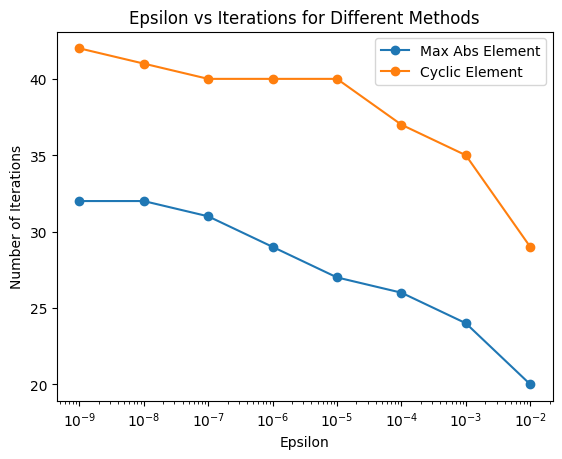

In [62]:
def experiment_epsilon_variation(A: np.ndarray, epsilons: list, max_iterations_count: int, get_element: Callable, label: str) -> None:
    iteration_counts = []

    for epsilon in epsilons:
        eigenvalues_result = find_eigen_values(A, epsilon, max_iterations_count, get_element)
        iteration_counts.append(eigenvalues_result.iterations_count)

    plt.plot(epsilons, iteration_counts, marker='o', label=label)

A = np.random.rand(5, 5)
A = A + A.T

epsilons = [10**(-i) for i in range(2, 10)]

experiment_epsilon_variation(A, epsilons, 1000, get_max_abs_element, "Max Abs Element")
experiment_epsilon_variation(A, epsilons, 1000, get_cyclic_element, "Cyclic Element")

plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('Number of Iterations')
plt.title('Epsilon vs Iterations for Different Methods')
plt.legend()
plt.show()

In [63]:
matrix_size = 5
hilbert_matrix = np.array([[generate_hilberts_matrix_element(row, column) for column in range(matrix_size)] for row in range(matrix_size)])

eigenvalues_result_first = find_eigen_values(hilbert_matrix, 1e-5, 1000, get_max_abs_element)
eigenvalues_result_second = find_eigen_values(hilbert_matrix, 1e-5, 1000, get_cyclic_element)
eigen_values_numpy, _ = np.linalg.eigh(hilbert_matrix)

print("Eigenvalues of Hilbert matrix, method 1:", eigenvalues_result_first.eigen_values)
print("Iterations to calculate eigenvalues of Hilbert matrix, method 1:", eigenvalues_result_first.iterations_count)

print("Eigenvalues of Hilbert matrix, method 2:", eigenvalues_result_second.eigen_values)
print("Iterations to calculate eigenvalues of Hilbert matrix, method 2:", eigenvalues_result_second.iterations_count)

Eigenvalues of Hilbert matrix, method 1: [1.56705069e+00 2.08534219e-01 3.05898013e-04 3.28795815e-06
 1.14074916e-02]
Iterations to calculate eigenvalues of Hilbert matrix, method 1: 24
Eigenvalues of Hilbert matrix, method 2: [1.56705069e+00 2.08534219e-01 3.28794630e-06 1.14074916e-02
 3.05898048e-04]
Iterations to calculate eigenvalues of Hilbert matrix, method 2: 38


In [64]:
epsilon = 1e-5
max_iterations = 1000

def gershgorin_circles(A: np.ndarray) -> Tuple[list, list]:
    lower_bounds = []
    upper_bounds = []

    for i in range(A.shape[0]):
        radius = sum(abs(A[i, j]) for j in range(A.shape[0]) if j != i)
        lower_bounds.append(A[i, i] - radius)
        upper_bounds.append(A[i, i] + radius)

    return lower_bounds, upper_bounds

def check_eigenvalues_within_bounds(eigenvalues: np.ndarray, lower_bounds: list, upper_bounds: list) -> None:
    for eigenvalue in eigenvalues:
        in_bounds = any(lower <= eigenvalue <= upper for lower, upper in zip(lower_bounds, upper_bounds))

        if not in_bounds:
            return False

    return True

hilbert_matrix = np.array([[generate_hilberts_matrix_element(row, column) for column in range(matrix_size)] for row in range(matrix_size)])
A = np.random.rand(5, 5)
A = A + A.T

hilbert_result_first = find_eigen_values(hilbert_matrix, epsilon, max_iterations, get_max_abs_element)
hilbert_result_second = find_eigen_values(hilbert_matrix, epsilon, max_iterations, get_cyclic_element)

A_result_first = find_eigen_values(A, epsilon, max_iterations, get_max_abs_element)
A_result_second = find_eigen_values(A, epsilon, max_iterations, get_cyclic_element)

hilbert_lower_bounds, hilbert_upper_bounds = gershgorin_circles(hilbert_matrix)
A_lower_bounds, A_upper_bounds = gershgorin_circles(A)

print(f"{check_eigenvalues_within_bounds(hilbert_result_first.eigen_values, hilbert_lower_bounds, hilbert_upper_bounds)}, {hilbert_result_first.iterations_count}")
print(f"{check_eigenvalues_within_bounds(hilbert_result_second.eigen_values, hilbert_lower_bounds, hilbert_upper_bounds)}, {hilbert_result_second.iterations_count}")
print(f"{check_eigenvalues_within_bounds(A_result_first.eigen_values, A_lower_bounds, A_upper_bounds)}, {A_result_first.iterations_count}")
print(f"{check_eigenvalues_within_bounds(A_result_second.eigen_values, A_lower_bounds, A_upper_bounds)}, {A_result_second.iterations_count}")

True, 24
True, 38
True, 28
True, 41
